# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Imports
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt         
from tqdm import tqdm
from time import time
import torch
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import os

from torchvision import datasets

%matplotlib inline                               
%config InlineBackend.figure_format = 'retina'

In [4]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


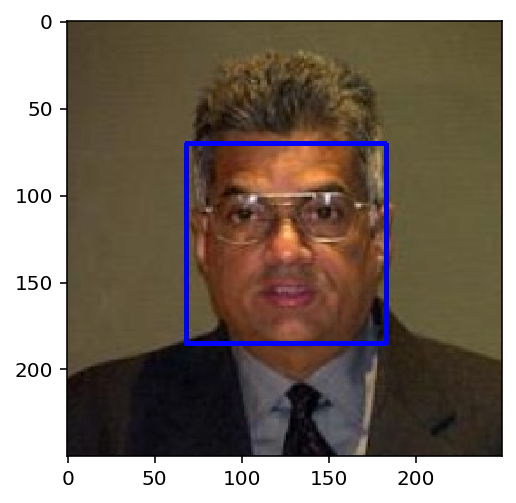

In [6]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (RGB) image and converts to BGR color channel order
img = cv2.imread(human_files[17])
# img = cv2.imread(dog_files[101])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector_haar(img_path, detector_type):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector_type.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [7]:
from tqdm import tqdm
from time import time

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detector_type = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

count = 0

start_time = time()
for image in human_files_short:
    faces = face_detector_haar(image, detector_type)
    count += faces
    
end_time = time()
tot_time = end_time - start_time
print('----Human Files----')
print('{}/{} human faces detected in {:5f} secs - {}% accurate'.format(count,len(human_files_short),
      tot_time, count/len(human_files_short)*100))

count = 0
start_time = time()                                                                       
for image in dog_files_short:    
    faces = face_detector_haar(image, detector_type)
    count += faces
    
end_time = time()
tot_time = end_time - start_time
print('----Dog Files----')
print('{}/{} human faces detected in {:5f} secs - {}% accurate'.format(count, len(dog_files_short),
                                                                       tot_time, 
                                                                       (len(dog_files_short)-count)/
                                                                       len(dog_files_short)*100))

----Human Files----
99/100 human faces detected in 1.192944 secs - 99.0% accurate
----Dog Files----
18/100 human faces detected in 5.632643 secs - 82.0% accurate


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
def face_detector_HOG(image, detector):
    img = dlib.load_rgb_image(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = face_detector(gray, 1)
    return (len(rects) > 0)

In [9]:

def face_detector_CNN(image, cnn_face_detector):
    img = dlib.load_rgb_image(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = cnn_face_detector(gray, 1)
    return (len(rects) > 0)

True
[(76, 86) (165, 176)]
Number of faces detected: 1


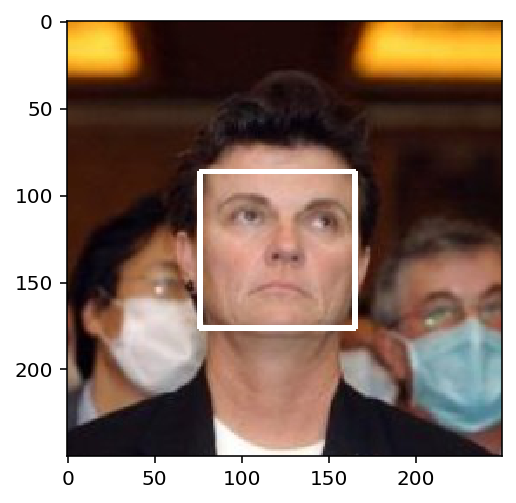

In [10]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

# ------ HOG Face detection -------
import dlib
from imutils import face_utils

img = dlib.load_rgb_image(human_files_short[99])
# img = dlib.load_rgb_image(dog_files_short[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_detector = dlib.get_frontal_face_detector()
rects = face_detector(gray, 1)
print(len(rects) > 0)

for (i, rect) in enumerate(rects):
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
    print(rect)
# print number of faces detected in the image
print('Number of faces detected:', len(rects))

plt.imshow(img)
plt.show()

True
Number of faces detected: 2
Detection 0: Left: 66 Top: 82 Right: 165 Bottom: 180 Confidence: 1.040
Detection 1: Left: 186 Top: 134 Right: 268 Bottom: 216 Confidence: 0.808


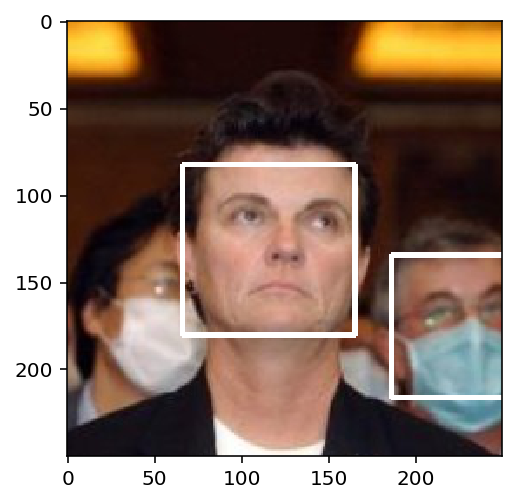

In [11]:
# ------ CNN face detection --------

img = dlib.load_rgb_image(human_files_short[99])
# img = dlib.load_rgb_image(dog_files_short[0])

cnn_face_detector = dlib.cnn_face_detection_model_v1('CNN/mmod_human_face_detector.dat')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dets = cnn_face_detector(gray, 1)
print(len(dets) > 0)

print("Number of faces detected: {}".format(len(dets)))
for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {:.3f}".format(
          i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
#     print(d.rect)
    x, y, w, h = d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()
    cv2.rectangle(img, (x, y), (w, h), (255, 255, 255), 2)
    
plt.imshow(img)
plt.show()

In [15]:
# Compare Haar, HOG and CNN face detectors

# haar_count = 0
# HOG_count = 0
# CNN_count = 0
count = 0

haar_face_detector = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
hog_face_detector = dlib.get_frontal_face_detector()
cnn_face_detector = dlib.cnn_face_detection_model_v1('CNN/mmod_human_face_detector.dat')

# ---- haar -----
start_time = time()
for image in human_files_short:
    rects = face_detector_haar(image, haar_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('Haar Cascade Face Detector')
print('----Human Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count,
      len(human_files_short), tot_time, count/len(human_files_short)*100))

count = 0
start_time = time()                                                                       
for image in dog_files_short:    
    rects = face_detector_haar(image, haar_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('----Dog Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count, len(dog_files_short),
                                                                       tot_time, 
                                                                       (len(dog_files_short)-count)/
                                                                       len(dog_files_short)*100))

# ---- HOG -----
start_time = time()
for image in human_files_short:
    rects = face_detector_HOG(image, hog_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('\n')
print('HOG Face Detector')
print('----Human Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count,
      len(human_files_short), tot_time, count/len(human_files_short)*100))

count = 0
start_time = time()                                                                       
for image in dog_files_short:    
    rects = face_detector_HOG(image, hog_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('----Dog Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count, len(dog_files_short),
                                                                       tot_time, 
                                                                       (len(dog_files_short)-count)/
                                                                       len(dog_files_short)*100))

# ---- CNN -----
start_time = time()
for image in human_files_short:
    rects = face_detector_CNN(image, cnn_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('\n')
print('CNN Face Detector')
print('----Human Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count,
      len(human_files_short), tot_time, count/len(human_files_short)*100))

count = 0
start_time = time()                                                                       
for image in dog_files_short:    
    rects = face_detector_CNN(image, cnn_face_detector)
    count += rects
    
end_time = time()
tot_time = end_time - start_time
print('----Dog Files----')
print('{}/{} human faces detected in {:.3f} secs - {:.2f}% accurate'.format(count, len(dog_files_short),
                                                                       tot_time, 
                                                                       (len(dog_files_short)-count)/
                                                                       len(dog_files_short)*100))

Haar Cascade Face Detector
----Human Files----
99/100 human faces detected in 1.136 secs - 99.00% accurate
----Dog Files----
18/100 human faces detected in 5.346 secs - 82.00% accurate


HOG Face Detector
----Human Files----
116/100 human faces detected in 1.864 secs - 116.00% accurate
----Dog Files----
8/100 human faces detected in 9.859 secs - 92.00% accurate


CNN Face Detector
----Human Files----
107/100 human faces detected in 32.181 secs - 107.00% accurate
----Dog Files----
3/100 human faces detected in 288.960 secs - 97.00% accurate


### Face Detection Results
The above compares Haar Cascade, HOG, and CNN face detection methods. Accuracy with the HOG and CNN methods is reflected in the number of faces detected. The above 100% accuracy represents the fact that more then one face is detected in some images. However, the reduction in speed is considerable.


<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move model to GPU if CUDA is available
VGG16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

np.mean: [0.6118533  0.44702488 0.36959241]
np.std: [0.21341386 0.22631503 0.23362314]


cv2.mean: [[0.61184471]
 [0.44703918]
 [0.36959423]]
cv2.std: [[0.21340384]
 [0.22630935]
 [0.23361529]]


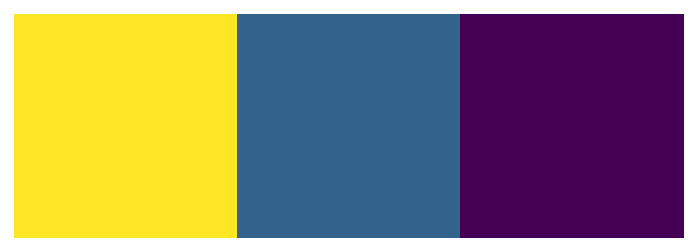

In [9]:
# Testing image color channel normalization
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

# Method using Numpy
image = human_files_short[0]
im = Image.open(image)
np_image = np.array(im)/255
mean_01 = np.mean(np_image, axis=(0, 1))
std_01 = np.std(np_image, axis=(0, 1))
print('np.mean: {}'.format(mean_01))
print('np.std: {}'.format(std_01))
print('\n')

# Method using OpenCV 
img_bgr = cv2.imread(image, cv2.IMREAD_COLOR)
channels_mean, channels_std = cv2.meanStdDev(img_bgr)
mean_02 = np.array([(channels_mean[2], channels_mean[1], channels_mean[0])])/255
std_02 = np.array([(channels_std[2], channels_std[1], channels_std[0])])/255
print('cv2.mean: {}'.format(mean_02[0]))
print('cv2.std: {}'.format(std_02[0]))

plt.imshow(mean_02[0].transpose())
plt.axis("off")
plt.show()

In [10]:
def load_class_dict(class_dict_path):
    """Loads ImageNet class idx to labels text file.
    
       Input:
           - file_path (str)
       
       Output:
           - imagenet_class_dict (dict)
    """
    with open(class_dict_path) as f:
        imagenet_class_dict = ast.literal_eval(f.read())
        
    return imagenet_class_dict

In [11]:
from PIL import Image
import torchvision.transforms as transforms
import ast 

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def process_image(image_path, dim=224):
    """Scales, crops (224 x 224 px), and normalizes a PIL image for a 
       Pytorch model.
       
       Arguments:
       - jpg image
       - dim (desired pixel size
       
       Returns:
       - Normalized Pytorch Tensor (image)
    """
    # resize image 
    im = Image.open(image_path)
    width, height = im.size
    if width > height:
        ratio = width/height
        im.thumbnail((ratio*256, 256))
    elif height > width:
        ratio = height/width
        im.thumbnail((256, ratio*256))
    new_width, new_height = im.size
    
    # crop image around center
    left = (new_width - dim)/2
    top = (new_height - dim)/2
    right = (new_width + dim)/2
    bottom = (new_height + dim)/2
    im = im.crop((left, top, right, bottom))
    
    # convert to a np.array and divide by the color channel (int max)
    np_image = np.array(im)/255
    
    # normalize color channels
    mean = np.mean(np_image, axis=(0, 1))
    std = np.std(np_image, axis=(0, 1))
    image = (np_image - mean)/std
    
    # convert to a Tensor - reorder color channel so it is first. Torch requirement
#     if torch.cuda.is_available():
#         image = torch.cuda.FloatTensor(image.transpose(2, 0, 1))
#     else:
#         image = torch.FloatTensor(image.transpose(2, 0, 1))
    image = torch.FloatTensor(image.transpose(2, 0, 1))
    return image

def VGG16_predict(img_path):
    """
        Use pre-trained VGG-16 model to obtain index corresponding to 
        predicted ImageNet class for image at specified path
    
        Args:
            img_path: path to an image
        
        Returns:
            Index corresponding to VGG-16 model's prediction
    """
    # move model to correct device
    device = torch.device("cpu")
    VGG16.to(device)
    
    with torch.no_grad():
        # process image
        image = process_image(img_path)
        image = image.unsqueeze_(0)
        image.to(device)
        
        output = VGG16(image)
        
        # convert output probabilities to predicted class
        _, class_tensor = torch.max(output, 1)

        # convert output tensor to numpy array
        class_pred = class_tensor.numpy()
        
    return  class_pred

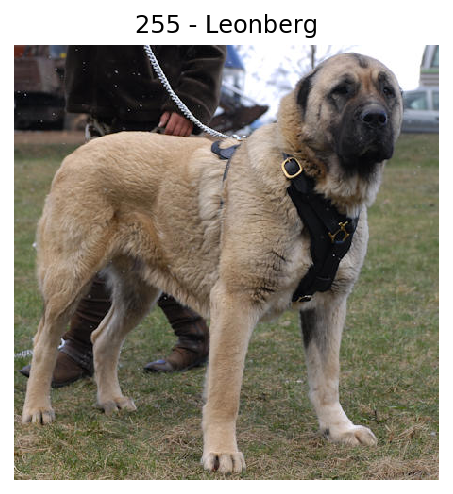

In [15]:
# image = 'images/Bloodhound_01906.jpg'
image = dog_files[4035]
class_dict_path = 'imagenet1000_clsidx_to_labels.txt'

# run image through model
class_pred = VGG16_predict(image)

# load dictionary and retrieve correct class and name
imagenet_class_dict = load_class_dict(class_dict_path)
dog_name = imagenet_class_dict[class_pred[0]]
# print(len(imagenet_class_dict))
# plot image

im = Image.open(image)

np_image = np.array(im)
plt.title('{} - {}'.format(class_pred[0], dog_name).title())
plt.axis('off')
plt.imshow(np_image)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
def dog_detector(img_path):
    """Returns True if a dog is detected in the supplied image.
    
       Arguments:
           - image path (str)
       Returns:
           - Boolean
    """
    # run image through model
    class_pred = VGG16_predict(img_path)
    
    # Imagenet class dictionary keys 151-268, inclusive, correspond to dog names
    if ((class_pred >= 151) and (class_pred <= 268)):
        return True
    else:
        return False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [95]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from time import time

# human files
start_time = time()
dogs = 0

for image in human_files_short:
    if dog_detector(image):
        dogs += 1

end_time = time()
tot_time = end_time - start_time
print('----Human Files----')
print('{}/{} dogs detected in {:.3f} secs - {:.2f}% accurate'.format(dogs, len(human_files_short),
                                                                     tot_time, 
                                                                     (len(human_files_short)-dogs)/
                                                                     len(human_files_short)*100))
print('\n')
# dog files
start_time = time()
dogs = 0
for image in dog_files_short:
    if dog_detector(image):
        dogs += 1

end_time = time()
tot_time = end_time - start_time
print('----Dog Files----')
print('{}/{} dogs detected in {:.3f} secs - {:.2f}% accurate'.format(dogs, len(dog_files_short),
                                                                       tot_time, dogs/len(dog_files_short)*100))

----Human Files----
1/100 dogs detected in 36.619 secs - 99.00% accurate


----Dog Files----
97/100 dogs detected in 38.620 secs - 97.00% accurate


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [20]:
def load_data(data_dir='dogImages'):
    
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    loaders_scratch = {}
    
    batch_size = 30
    img_mean = [0.485, 0.456, 0.406]
    img_std = [0.229, 0.224, 0.225]
    
    # define transforms for the training, validation and testing sets
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                            transforms.RandomRotation(90),
                                            transforms.RandomHorizontalFlip(p=0.4),
                                            transforms.ToTensor(),
                                            transforms.Normalize(img_mean, img_std)])
    
    valid_test_transforms = transforms.Compose([transforms.Resize(226),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(img_mean, img_std)])
    
    # load the datasets with ImageFolder function and DataLoader
    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
    test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)
    
    loaders_scratch['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loaders_scratch['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    loaders_scratch['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return loaders_scratch

In [18]:
# print helper function
def imgshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose(1, 2, 0)
    
    if normalize:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    
    return ax

In [173]:
# looking at the min/max image sizes in dogImages folder
import operator

img_size_dict = {}
for i, image_path in enumerate(dog_files):
    im = Image.open(image_path)
    width, height = im.size
    img_size_dict[i] = [width, height]

print('Max - {}'.format(max(img_size_dict.items(), key=operator.itemgetter(1))))
print('Min - {}'.format(min(img_size_dict.items(), key=operator.itemgetter(1))))

Max - (6420, [4278, 3744])
Min - (211, [105, 120])


torch.Size([30, 3, 224, 224])


<Figure size 864x360 with 0 Axes>

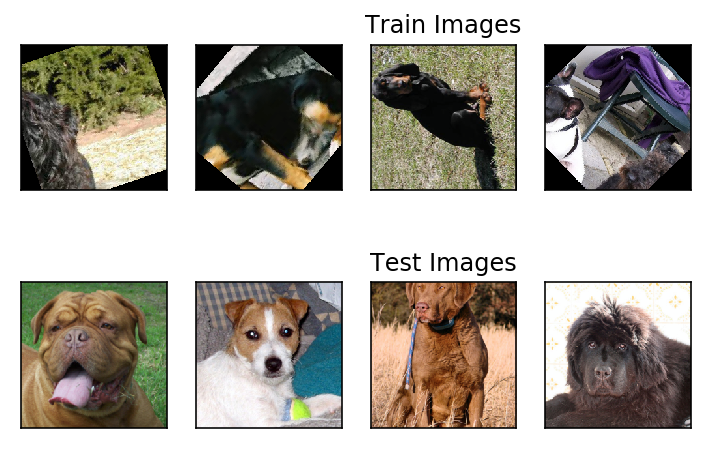

In [21]:
# look at some images
loaders_scratch = load_data()
train_imgs = next(iter(loaders_scratch['train']))
test_imgs = next(iter(loaders_scratch['test']))
print(train_imgs[0].shape)
plt.figure(figsize=[12,5])
n_cols = 4
fig, axes = plt.subplots(nrows=2, ncols=n_cols)

for i in range(4):
    ax1 = axes[0][i]
    ax2 = axes[1][i]
    imgshow(train_imgs[0][i], ax=ax1, normalize=True)
    imgshow(test_imgs[0][i], ax=ax2, normalize=True)
    
axes[0][2].set_title('Train Images')
axes[1][2].set_title('Test Images')
plt.show()

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I chose to separate my image transforms into two categories; `train_transforms` and `valid_test_transforms`.
The input tensor is in batch size of 32 with dimensions 400x400. I feel that this size retained much of the image information.

__training data__ -- I chose to resize and crop the images, then roate and flip them. This helps with training in that it presents some variance in the data. However, I did notice that in some images the dogs are not necessaily centered. By simply cropping the image there is a good possibility that a portion of the dog in the image will be cut off.

__test data__ --  I chose to simple do a resize and center crop with the test data.

In both cases I normalized the color channels to provided faster training.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [22]:
# import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
loaders_scratch = load_data()

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.batch4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128*14*14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 133)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        ## Define forward behavior
        # input (224)
        x = F.relu(self.batch1(self.conv1(x)))
        x = self.pool(x)
#         print(x.shape) # 112
        
        x = F.relu(self.batch2(self.conv2(x)))
        x = self.pool(x)
#         print(x.shape) # 56
        
        x = F.relu(self.batch3(self.conv3(x)))
        x = self.pool(x)
#         print(x.shape) # 28
        
        x = F.relu(self.batch4(self.conv4(x)))
        x = self.pool(x)
#         print(x.shape) # 14
        
        # Flatten
        x = x.view(x.shape[0], -1)
#         print(x.shape)
        
        # fully connected layers 
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
#         print(x.shape)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
#     print(use_cuda)

In [23]:
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=133, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

### Initial Steps
• __Conv Layers:__ *input --> 16 --> 32 --> 64  
• __FC Layers:__ *input --> 512 --> 133  
• __Activation:__ ReLU on all fully connected layers  
• __Pooling:__ Maxpooling on all convultional layers  
• __Reasoning:__ This intially proved to be a very slow process with little to no reduction in training and validation loss rate. Loss rate did not lower after 25 epocs.   

### Intermediate Steps
After a lot of trial and error I decided to give more depth to the convolutional layers, ultimatly ending on the final structure of: input --> 32 --> 64 --> 128. This seemed to make a little difference but utimatly it did not affect the loss rate. I did some research and decided to add a BatchNorm2d processing to each of the convolutional layers. According to the [Batch Normalization](https://arxiv.org/abs/1502.03167) paper there typically is an increase in performance when using BatchNorm2d in Pytorch.

### Final Steps
• __Conv Layers:__ *input --> 32 --> 64 --> 128 --> 128  
• __FC Layers:__ *input --> 512 --> 133  
• __Activation:__ ReLU on all fully connected layers  
• __Pooling:__ Maxpooling on all convultional layers  
• __BatchNorm2d:__ Applied batch normalization to each convolutional layer to speed up performance  
• __Momentum:__ Added momentum of 0.7 in the Stochastic Gradient Decent optimizer to reduce the probability of convergence at a local minimum.   
• __Reasoning:__ This intially proved to be a very slow process with little to no reduction in training and validation loss rate. Loss rate did not lower after 25 epocs.   




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [183]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.7)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [210]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses, valid_losses = [], []
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer_scratch.zero_grad() # clear the gradients
            output = model_scratch(data)
            loss = criterion_scratch(output, target)
            loss.backward()
            optimizer_scratch.step()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
#             train_loss += loss.item()
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model_scratch(data)
            loss = criterion_scratch(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.3f} --> {:.3f}). Saving model ...'.format(
        valid_loss_min, valid_loss))
        
        torch.save(model_scratch.state_dict(), save_path)
    # return trained model
    return model_scratch


# train the model
model_scratch = train(1, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 6.908754 	Validation Loss: 6.907883
Validation loss decreased (inf --> 6.908). Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = None
optimizer_transfer = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)